In [4]:
FASTA="../annotate/data/FASTA"
NIDO="../annotate/in/Nidovirales.fasta"
PROFILE="./aln/F189.aln.fasta"

m8_file_path = "./F189-search/alnResult.m8"




### 1. parse seq id 

In [5]:
import pandas as pd

# Load the .m8 file into a pandas DataFrame

columns = [
    'query', 'subject', 'percentage_identity', 'alignment_length',
    'mismatches', 'gap_opens', 'query_start', 'query_end', 
    'subject_start', 'subject_end', 'e_value', 'bit_score'
]
m8_df = pd.read_csv(m8_file_path, sep='\t', names=columns)

# Extract unique sequence identifiers
sequence_ids = set(m8_df['query']).union(set(m8_df['subject']))

### Step 2: Fetch sequences from a FASTA file

In [10]:
from Bio import SeqIO

# Load sequences from a FASTA file
sequences:dict = {}
Sources = [PROFILE, NIDO, FASTA]
for fasta_file_path in Sources:
    for record in SeqIO.parse(fasta_file_path, 'fasta'):
        if record.id not in sequences:
            sequences = { **sequences, record.id: record}
#sequences = {record.id: record for record in SeqIO.parse(fasta_file_path, 'fasta')}

# Filter sequences based on the unique identifiers from the .m8 file
filtered_sequences = [sequences[seq_id] for seq_id in sequence_ids if seq_id in sequences]



### Step 3: Write to a multifasta file

In [11]:
# Write the filtered sequences to a multifasta file
output_fasta_file_path = 'F189-search/filtered_sequences.fasta'
with open(output_fasta_file_path, 'w') as output_handle:
    SeqIO.write(filtered_sequences, output_handle, 'fasta')

# _________________________________________________________________________________________________________________

### workflow

1. adding sequence "polymerase" from francois                       **&rarr; NO**
2. retreve fasta seq from all record                                **&rarr; OK**
3. filter - remove redundancy - cluster                             **&rarr; OK**
4. align -> tree                                                    **&rarr; OK**
5. cluster -> network graph (qvge --balloon)                        **&rarr; OK**
6. locate MOTIF (Shannon et al, 2020) -> cut-off entropy -> MOTIF   **&rarr; ...**
7. short align -> leaders -> Espript
8. heatmap , test with all profile sequences

2. retreve fasta seq from all record

### txid2501931[Organism:exp] AND refseq[filter]

3. filter - remove redundancy - cluster  

In [ ]:
cd '/home/vincentwilde/Documents/thesis_1/Testymolo/testymolo/datamolo/scr/workinprogress/profile'

PROFILE="./aln/F189.aln.fasta"
Orthocoronavirinae="./in/Orthocoronaviridae.fasta"
OUT="./F189-search/alnResult.m8"
tmp="./F189-search/tmp"

mmseqs easy-search $PROFILE $Orthocoronavirinae $OUT $tmp

In [ ]:
# Set working directory
cd '/home/vincentwilde/Documents/thesis_1/Testymolo/testymolo/datamolo/scr/workinprogress/profile'

# Create necessary directories
mkdir -p "./F189-search/PROFILE"
mkdir -p "./F189-search/Orthocoronaviridae"
mkdir -p "./F189-search/OUT"

# Define relative paths
PROFILE_f_p="./aln/F189.aln.fasta"
PROFILE="./F189-search/PROFILE/PROFILE"
Orthocoronavirinae_f_p="./in/Orthocoronaviridae.fasta"
Orthocoronavirinae="./F189-search/Orthocoronaviridae/Orthocoronaviridae"
OUT_m8="./F189-search/alnResult.m8"
tmp="./F189-search/tmp"

# Create MMseqs2 databases
mmseqs createdb $PROFILE_f_p $PROFILE -v 0
mmseqs createdb $Orthocoronavirinae_f_p $Orthocoronavirinae -v 0

# Perform search
OUT_db="./F189-search/OUT/OUT_db"
mmseqs search $PROFILE $Orthocoronavirinae $OUT_db $tmp

# Extract sequences from search results (this step ensures we have sequence data, not alignments)
OUT_db_m8="./F189-search/OUT/OUT_db_m8"
mmseqs conversalis $PROFILE $Orthocoronaviridae $OUT_db $OUT_db_m8 --extract-seq

# Cluster the sequences
OUT_clu="./F189-search/OUT/OUT_clu"
mmseqs cluster $OUT_db_m8 $OUT_clu $tmp --min-seq-id 0.9 

# Export clustering results to TSV format
OUT_clu_tsv="./F189-search/OUT/OUT_clu_tsv"
mmseqs createtsv $OUT_db $OUT_clu $OUT_clu_tsv

# Optionally convert to .m8 format if needed
# If you need to align the sequences and then convert to .m8 format
mmseqs align $PROFILE $Orthocoronavirinae $OUT_db $tmp
mmseqs convertalis $PROFILE $Orthocoronavirinae $OUT_db $OUT_m8

In [7]:
import pandas as pd

# Load the .m8 file into a pandas DataFrame
m8_file_path="./F189-search/alnResult.m8"

columns = [
    'query', 'subject', 'percentage_identity', 'alignment_length',
    'mismatches', 'gap_opens', 'query_start', 'query_end', 
    'subject_start', 'subject_end', 'e_value', 'bit_score'
]
m8_df = pd.read_csv(m8_file_path, sep='\t', names=columns)
# Extract unique sequence identifiers
sequence_ids = set(m8_df['query']).union(set(m8_df['subject']))

In [ ]:
#if percentage of identity is 1 : redundancy 
filtered_df = m8_df[m8_df['percentage_identity'] == 1.0]
count = filtered_df.shape[0]
print(count)
# => 0 : no redundancy 

In [9]:
from Bio import SeqIO

# Load sequences from a FASTA file
PROFILE = "./aln/F189.aln.fasta"
sequences_PROFILE = {record.id: record for record in SeqIO.parse(PROFILE, 'fasta')}

# Filter sequences based on the unique identifiers from the .m8 file
filtered_sequences_PROFILE = [sequences_PROFILE[seq_id] for seq_id in sequence_ids if seq_id in sequences_PROFILE]


Orthocoronavirinae="./in/Orthocoronaviridae.fasta"
sequences_Orthocoronavirinae = {record.id: record for record in SeqIO.parse(Orthocoronavirinae, 'fasta')}
filtered_sequences_Orthocoronavirinae = [sequences_Orthocoronavirinae[seq_id] for seq_id in sequence_ids if seq_id in sequences_Orthocoronavirinae]


filtered_sequences = filtered_sequences_PROFILE + filtered_sequences_Orthocoronavirinae

In [10]:
# Write the filtered sequences to a FASTA file
output_fasta_file_path = './F189-search/filtered_sequences_Orthocoronavirinae.fasta'
with open(output_fasta_file_path, 'w') as output_handle:
    SeqIO.write(filtered_sequences, output_handle, 'fasta')


out_all_[5668-6645]_aligned_filtered_sequences_Orthocoronavirinae.fasta

5. cluster -> graph

In [1]:
import pandas as pd

# Load the .m8 file into a pandas DataFrame
m8_file_path = "./F189-search/alnResult.m8"
columns = [
    'query', 'subject', 'percentage_identity', 'alignment_length',
    'mismatches', 'gap_opens', 'query_start', 'query_end', 
    'subject_start', 'subject_end', 'e_value', 'bit_score'
]
m8_df = pd.read_csv(m8_file_path, sep='\t', names=columns)

########################################################################################################

import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in m8_df.iterrows():
    G.add_edge(row['query'], row['subject'], e_value=row['e_value'], bit_score=row['bit_score'])

#########################################################################################################

# Export to GraphML
nx.write_graphml(G, f"./F189-search/OUT/network_graph.graphml")

# Export to GEXF
nx.write_gexf(G, f"./F189-search/OUT/network_graph.gexf")

Original DataFrame:
   A  B  C
0  0  1  1
1  1  1  1
2  1  1  0


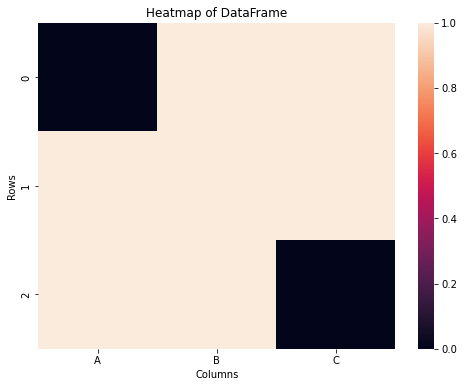

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
data = {
    'A': [0, 1, 1],
    'B': [1, 1, 1],
    'C': [1, 1, 0]
}
df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)

# Plotting a heatmap using seaborn
plt.figure(figsize=(8, 6))
#sns.heatmap(df, annot=False, cmap='coolwarm', linewidths=0.5, linecolor='gray', fmt='.1f')
sns.heatmap(df, annot=False, vmin=0, vmax=1)#, cmap='coolwarm', linewidths=0.5, linecolor='gray', fmt='.1f')
plt.title('Heatmap of DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()